In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

In [19]:
train_data=datasets.MNIST('MNIST_data',
                     train=True,
                     download=True,
                     transform=transforms.Compose([transforms.ToTensor()]))
test_data=datasets.MNIST('MNIST_data',
                     train=False,
                     download=True,
                     transform=transforms.Compose([transforms.ToTensor()]))

In [20]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [21]:
def plot(x):
    img=(np.array(x.detach(), dtype='float')).reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.show()

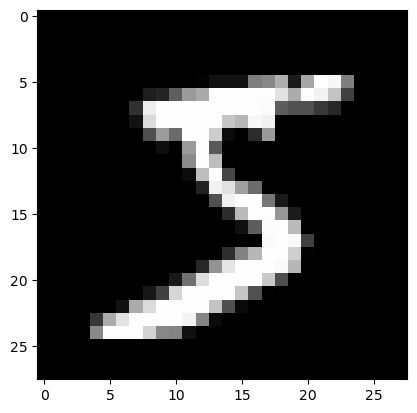

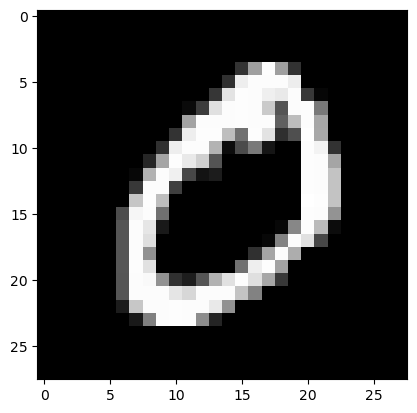

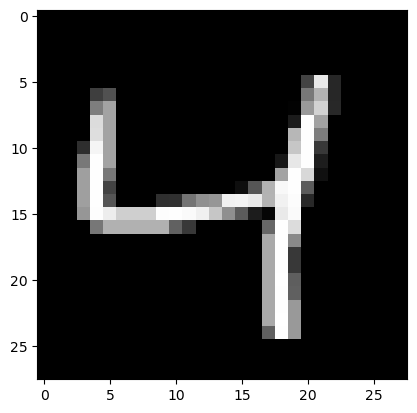

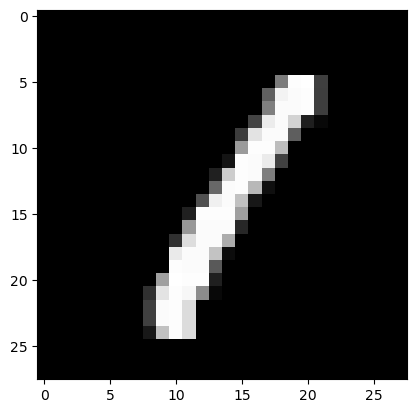

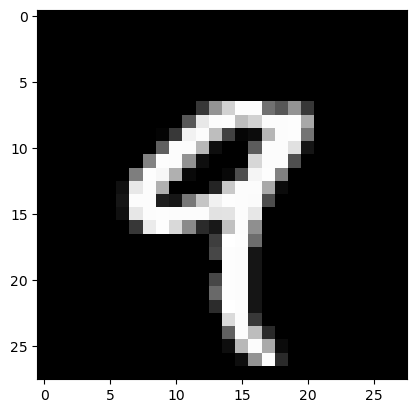

In [22]:
for i in range(5):
    plot(train_data.data[i])

In [23]:
for i in range(5):
    print(train_data.targets[i])

tensor(5)
tensor(0)
tensor(4)
tensor(1)
tensor(9)


In [24]:
x=train_data.data.float()/255 #0~1사이의 값에서 정규화
y=train_data.targets
x=x.view(x.size(0), -1) # 이차원 이미지 1차원으로 변경
print(x.size())
print(y.size())
input_size=x.size(-1) # 입력데이터 크기
output_size=int(max(y))+1 # 출력 클래스
print(input_size, output_size)

torch.Size([60000, 784])
torch.Size([60000])
784 10


In [25]:
# Train/Valid 분리
ratio=[0.8, 0.2]

train_cnt=int(x.size(0)*ratio[0])
valid_cnt=int(x.size(0)*ratio[1])
test_cnt=len(test_data.data)
print(train_cnt, valid_cnt, test_cnt)
cnts=[train_cnt, valid_cnt]

indices=torch.randperm(x.size(0))
x=torch.index_select(x, dim=0, index=indices)
y=torch.index_select(y, dim=0, index=indices)

x1=list(x.split(cnts, dim=0))
y1=list(y.split(cnts, dim=0))
print(x1[0].shape, x1[1].shape, y1[0].shape, y1[1].shape)

x1+=[(test_data.data.float()/255).view(test_cnt, -1)]
y1+=[test_data.targets]

#a=[1,2,3]
#b=[10,20,30]
#[(1,10),(2,30),(3,30)]
for x_i, y_i in zip(x1, y1): #[(x1[0],y1[0]),(x1[1],y1[1]),(x1[2],y1[2])
    print(x_i.size())

48000 12000 10000
torch.Size([48000, 784]) torch.Size([12000, 784]) torch.Size([48000]) torch.Size([12000])
torch.Size([48000, 784])
torch.Size([12000, 784])
torch.Size([10000, 784])


In [26]:
model=nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1)
)
model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [27]:
crit=nn.NLLLoss()
optimizer=optim.Adam(model.parameters())

In [28]:
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')

In [29]:
model=model.to(device)
x2=[x_i.to(device) for x_i in x1]
y2=[y_i.to(device) for y_i in y1]

In [30]:
epochs=1000
batch_size=256
print_interval=10

In [31]:
from copy import deepcopy
lowest_loss=np.inf # 최소 비용함수값 저장
best_model=None

early_stop=50  # 
lowest_epoch=np.inf # 최소 비용함수값을 가지는 epoch

In [32]:
train_history, valid_history=[],[]

for i in range(epochs):
    indices=torch.randperm(x2[0].size(0)).to(device)
    x_=torch.index_select(x2[0], dim=0, index=indices)
    y_=torch.index_select(y2[0], dim=0, index=indices)

    x_=x_.split(batch_size, dim=0) # list size 48000/256
    y_=y_.split(batch_size, dim=0)

    train_loss, valid_loss=0,0
    y_hat=[]

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss+=float(loss)
    train_loss=train_loss/len(x_)  #len(x_)=4800/256

    with torch.no_grad():
        x_=x2[1].split(batch_size, dim=0)
        y_=y2[1].split(batch_size, dim=0)
        valid_loss=0

        for x_i, y_i in zip(x_, y_):
            y_hat_i=model(x_i)
            loss=crit(y_hat_i, y_i.squeeze())
            valid_loss +=float(loss)

            y_hat+=[y_hat_i]
    valid_loss= valid_loss/len(x_)

    train_history +=[train_loss]  
    valid_history +=[valid_loss]

    if (i+1) % print_interval==0:
        print(i, train_loss, valid_loss, lowest_loss)

    if valid_loss <= lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i

        best_model=deepcopy(model.state_dict())
    
    else:
        if early_stop > 0 and lowest_epoch+early_stop < i+1:
            print('%d이후 %d epoch 증가하는 동안 손실함수 감소가 없음'%(lowest_epoch, early_stop))
            break
        
print('epoch %d일때 손실함수 %.4f가 검증데이터로 가장 낮은 손실함수을 가짐'%(lowest_epoch+1, lowest_loss))    

9 0.027937534966808248 0.08764177180351095 0.08794665257347391
19 0.01725101732618567 0.08976822885427069 0.08764177180351095
29 0.007167298099220522 0.09711226131370727 0.08764177180351095
39 0.002077303822832309 0.1017468698481296 0.08764177180351095
49 0.0077962953783811675 0.10258734885583375 0.08764177180351095
59 0.002012827762817498 0.13767071698415786 0.08764177180351095
9이후 50 epoch 증가하는 동안 손실함수 감소가 없음
epoch 10일때 손실함수 0.0876가 검증데이터로 가장 낮은 손실함수을 가짐


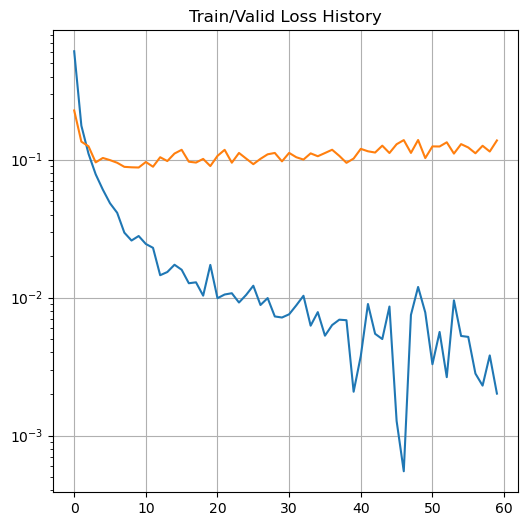

In [33]:
plot_from=0
plt.figure(figsize=(6,6))
plt.grid(True)
plt.title("Train/Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.yscale('log')
plt.show()

In [34]:
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=x2[-1].split(batch_size, dim=0) # 10000/256
    y_=y2[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i, y_i.squeeze())

        test_loss+=loss
        y_hat+=[y_hat_i]

test_loss=test_loss/len(x_)
y_hat=torch.cat(y_hat, dim=0)

print('test loss:', test_loss)

test loss: tensor(0.1328)


In [35]:
correct_cnt=(y2[-1].squeeze()==torch.argmax(y_hat, dim=-1)).sum()
total_count=float(y2[-1].size(0))
print('accuracy:',(correct_cnt/total_count).item())

accuracy: 0.984000027179718


In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y2[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d'%i for i in range(10)],
             columns=['pred_%d'%i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,972,1,0,0,0,0,2,0,3,2
true_1,1,1129,2,0,0,0,1,0,2,0
true_2,2,0,1020,1,0,0,1,5,3,0
true_3,1,0,5,988,0,5,0,5,4,2
true_4,2,0,3,0,965,0,4,1,1,6
true_5,2,0,0,7,1,867,7,2,5,1
true_6,3,2,1,0,4,2,945,0,1,0
true_7,1,2,7,1,1,0,0,1015,0,1
true_8,3,1,1,1,1,3,0,4,957,3
true_9,2,3,0,2,7,1,0,8,4,982


In [39]:
pred=model((x2[2][0]).view(-1,784))
print(torch.argmax(pred,-1))
print(y2[-1][0])

tensor([7])
tensor(7)
